## Tiatanic - Machine learning from disaster

1. Problem
2. Data
3. Evaluation
4. Features

## 1. Problem

`identify and predict people who are going to survive or not survive during the Titanic in 1912.`

## 2. Data 
Data was downloaded from Kaggle competition: https://www.kaggle.com/competitions/titanic/overview

## 3. Evaluation
Predict in percentages people who are going to survive using `Accuracy` metrics.

## 4. Features

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
from sklearn.metrics import recall_score, precision_score
%matplotlib inline

In [3]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Checking and Filling the missing values

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_tmp = df.copy()

In [12]:
median_age = df_tmp['Age'].median()

In [13]:
df_tmp['Age'].fillna(median_age, inplace=True)

In [14]:
df_tmp.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
df_tmp.Cabin

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [16]:
df_tmp['Cabin'].fillna('Unknown', inplace=True)

In [17]:
df_tmp.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64

In [23]:
df_tmp['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [24]:
df_tmp['Embarked'].fillna('S', inplace=True)

In [25]:
df_tmp.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Plotting the data

In [26]:
survived_sex = pd.crosstab(df_tmp.Survived, df_tmp.Sex)
survived_sex

Sex,female,male
Survived,,
0,81,468
1,233,109


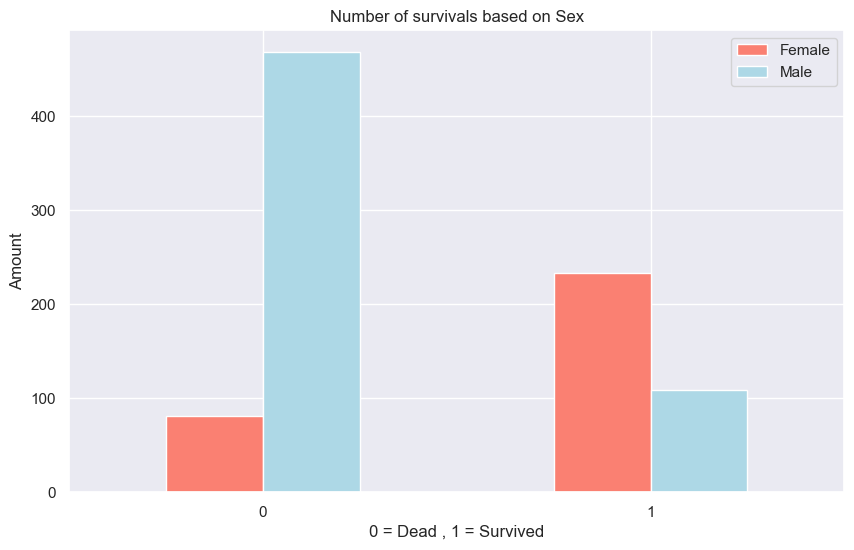

In [29]:
survived_sex.plot(kind='bar',
                figsize=(10,6),
                color=['salmon', 'lightblue']);
plt.title('Number of survivals based on Sex')
plt.xlabel('0 = Dead , 1 = Survived')
plt.ylabel('Amount')
plt.legend(['Female', 'Male'])
plt.xticks(rotation=0);

## Preprocessed data

In [30]:
def preprocessed_data(df):
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna('S', inplace=True)
    df['Cabin'].fillna('Unknown', inplace=True)
    for label, content in df.items():
       if not pd.api.types.is_numeric_dtype(content):
    # We add +1 to the category cuz pandas encodes missing val as -1
            df[label] = pd.Categorical(content).codes+1
    return df

In [42]:
for label, content in df_tmp.items():
       if not pd.api.types.is_numeric_dtype(content):
    # We add +1 to the category cuz pandas encodes missing val as -1
            df_tmp[label] = pd.Categorical(content).codes+1

## Splitting data into Train/Test sets

In [43]:
X, y = df_tmp.drop('Survived', axis=1), df_tmp['Survived']

In [44]:
X[:10]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,109,2,22.0,1,0,524,7.2500,148,3
1,2,1,191,1,38.0,1,0,597,71.2833,82,1
2,3,3,354,1,26.0,0,0,670,7.9250,148,3
3,4,1,273,1,35.0,1,0,50,53.1000,56,3
4,5,3,16,2,35.0,0,0,473,8.0500,148,3
5,6,3,555,2,28.0,0,0,276,8.4583,148,2
6,7,1,516,2,54.0,0,0,86,51.8625,130,3
7,8,3,625,2,2.0,3,1,396,21.0750,148,3
8,9,3,413,1,27.0,0,2,345,11.1333,148,3
9,10,2,577,1,14.0,1,0,133,30.0708,148,1


In [45]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Creating a model
logreg = LogisticRegression(n_jobs=-1, verbose=2)
# Fit the model
logreg.fit(X_train, y_train)
# Score the model
logreg_score = logreg.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


In [50]:
# creating RandomForestClassifier model
clf = RandomForestClassifier(n_jobs=-1, verbose=2)
# fitting the model
clf.fit(X_train, y_train)
# Score the model
clf_score = clf.score(X_test, y_test)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [71]:
# AdaBoost
# Create Estimator 
base_estimator = DecisionTreeClassifier(max_depth=1)
# Create AdaBoost model
ada_clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, random_state=42)
# Fit model
ada_clf.fit(X_train, y_train)
# Score model
ada_clf_score = ada_clf.score(X_test, y_test)

In [72]:
# GradientBooster
grd_clf = GradientBoostingClassifier()
# Fit the model
grd_clf.fit(X_train, y_train)
# Score the model 
grd_clf_score = grd_clf.score(X_test, y_test)

In [73]:
scores = pd.DataFrame({'RandomForestClassifier' : [clf_score],
                       'LogisticRegression': [logreg_score],
                       'AdaBoostClassifier': [ada_clf_score],
                       'GradientBoostingClassifier': [grd_clf_score]})

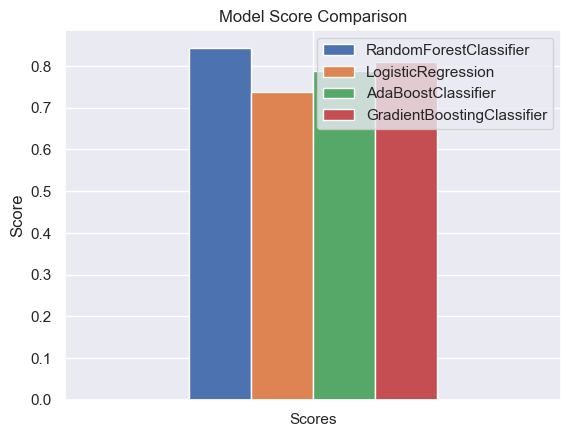

In [74]:
scores.plot(kind='bar')
plt.title('Model Score Comparison')
plt.ylabel('Score')
plt.xticks(range(len(scores)), ['Scores'], rotation=0)
plt.legend()
plt.show()

## K-fold-cross-validation

In [75]:
kf = KFold(n_splits=8)
# cross-validation on LogisticRegression
CVS_logreg = cross_val_score(logreg, X_train, y_train, cv=kf)
# cross-validation on RandomForestClassifier
CVS_clf = cross_val_score(clf, X_train, y_train, cv=kf)
# cross-validation on GradientBoostingClassifier
CVS_grd_clf = cross_val_score(grd_clf, X_train, y_train, cv=kf)
# cross-validation on AdaBoost
CVS_ada_clf =cross_val_score(ada_clf, X_train, y_train, cv=kf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out

In [76]:
print(f'Accuracy scores for each fold in LogisticRegression: {CVS_logreg}, with Average Cross-Validation-Score: {CVS_logreg.mean()}')
print(f'Accuracy scores for each fold in RandomForestClassifier: {CVS_clf}, with Average Cross-Validation-Score: {CVS_clf.mean()}')
print(f'Accuracy scores for each fold in GradientBoostingClassifier: {CVS_grd_clf}, with Average Cross-Validation-Score: {CVS_grd_clf.mean()}')
print(f'Accuracy scores for each fold in AdaBoost: {CVS_ada_clf}, with Average Cross-Validation-Score: {CVS_ada_clf.mean()}')

Accuracy scores for each fold in LogisticRegression: [0.80898876 0.71910112 0.82022472 0.78651685 0.78651685 0.69662921
 0.66292135 0.82022472], with Average Cross-Validation-Score: 0.7626404494382023
Accuracy scores for each fold in RandomForestClassifier: [0.78651685 0.7752809  0.84269663 0.87640449 0.82022472 0.80898876
 0.76404494 0.91011236], with Average Cross-Validation-Score: 0.8230337078651685
Accuracy scores for each fold in GradientBoostingClassifier: [0.80898876 0.82022472 0.85393258 0.88764045 0.82022472 0.78651685
 0.7752809  0.8988764 ], with Average Cross-Validation-Score: 0.8314606741573034
Accuracy scores for each fold in AdaBoost: [0.79775281 0.79775281 0.83146067 0.88764045 0.80898876 0.75280899
 0.70786517 0.84269663], with Average Cross-Validation-Score: 0.8033707865168539


## Evaluation of the models so far
After exploring 4 different Classification Models (LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, AdaBoost) We can see the patterns and we can make one assumption for now:

The best performing model at this moment is: `GradientBoostingClassifier`, 

for the second place we can put `RandomForestClassifier`, 

and third place goes for `AdaBoost`.

We will leave behind LogisticRegression for now, and try to perform RandomSearchCV on our models.

## Hyperparameter Tuning

In [78]:
# Parameters for GradientBoostingClassifier
gdb_params = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Parameters for RandomForestClassifier
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Parameters for AdaBoostClassifier
ada_params = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 1.0),
    'algorithm': ['SAMME', 'SAMME.R']
}

## GradientBoostingClassifier Hyperparameter tuning with RandomizedSearchCV

In [79]:
# GradientBoostingClassifier - RandomSearchCV
gb_random_search = RandomizedSearchCV(GradientBoostingClassifier(), gdb_params, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# Fit the best combination
gb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D1C7A88820>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7A19C40>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7A881C0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7B61520>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7A8D940>},
                   random_state=42, verbose=2)

In [80]:
gb_random_search.best_params_

{'learning_rate': 0.12518491505161694,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 195}

In [87]:
grd_clf = GradientBoostingClassifier(learning_rate=0.12518491505161694, 
                                     max_depth=5, 
                                     max_features='log2',
                                     min_samples_leaf=1,
                                     min_samples_split=8,
                                     n_estimators=195)

# Fit model with tuned parameters
grd_clf.fit(X_train, y_train)

# Score the Tunned model
tuned_grd_clf_score = grd_clf.score(X_test, y_test)
tuned_grd_clf_score

0.8491620111731844

## RandomForestClassifier HyperParameter Tuning with RandomizedSearchCV

In [84]:
# RandomForestClassifier - RandomizedSearchCV
rf_random_search = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# Fit the best combination
rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C78AFD30>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7AB5790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7B61400>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7A8DD60>},
                   random_state=42, verbose=2)

In [85]:
rf_random_search.best_params_

{'bootstrap': False,
 'max_depth': 16,
 'max_features': 'log2',
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 464}

In [88]:
tuned_rf = RandomForestClassifier(bootstrap=False,
                                  max_depth=16,
                                  max_features='log2',
                                  min_samples_leaf=6,
                                  min_samples_split=7,
                                  n_estimators=464)

# Fit Tunned model
tuned_rf.fit(X_train, y_train)

# Score improved model
tuned_rf_clf_score = tuned_rf.score(X_test, y_test)
tuned_rf_clf_score

0.8435754189944135

## AdaBoostClassifier HyperParameter Tuning using RandomizedSearchCV

In [89]:
# AdaBoostClassifier - RandomizedSearchCV
ada_random_search = RandomizedSearchCV(AdaBoostClassifier(), ada_params, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# Fit the best combination
ada_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D1C7AB58B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D1C7B619D0>},
                   random_state=42, verbose=2)

In [90]:
ada_random_search.best_params_

{'algorithm': 'SAMME',
 'learning_rate': 0.7822447692966574,
 'n_estimators': 185}

In [91]:
tuned_ada_clf = AdaBoostClassifier(algorithm='SAMME',
                                   learning_rate=0.7822447692966574,
                                   n_estimators=185)

# Fit the Tuned model
tuned_ada_clf.fit(X_train, y_train)
# Score the improved model
tuned_ada_clf_score = tuned_ada_clf.score(X_test, y_test)
tuned_ada_clf_score

0.8044692737430168

## Choosing the model - Final decision

In [92]:
imporoved_scores = pd.DataFrame({'RandomForestClassifier' : [tuned_rf_clf_score],
                       'AdaBoostClassifier': [tuned_ada_clf_score],
                       'GradientBoostingClassifier': [tuned_grd_clf_score]})

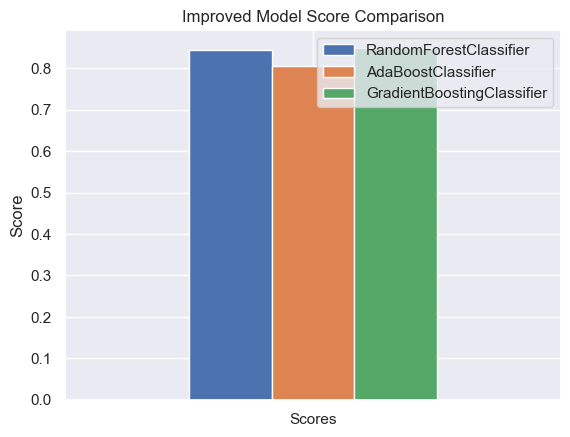

In [93]:
imporoved_scores.plot(kind='bar')
plt.title('Improved Model Score Comparison')
plt.ylabel('Score')
plt.xticks(range(len(scores)), ['Scores'], rotation=0)
plt.legend()
plt.show()

In [94]:
imporoved_scores

,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
0,0.843575,0.804469,0.849162


### As we can see `GradientBoostingClassifier` showed the best results after careful HyperParameter tuning process, only slightly overperforming `RandomForestClassifier`. 

## Measuring `Accuracy`.

In [100]:
# let's make predictions with our best model - GradientBoostingClassifier
y_preds = grd_clf.predict(X_test)
# Create a function to calculaion Accuracy scores
def show_scores(y_test, y_preds):
    '''
    Outputs the following scores of your model: 
    Accuracy, Precision, Recall, F1.
    '''
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    print(f'''
    Accuracy score: {accuracy},
    Precision: {precision},
    Recall score: {recall},
    F1 score: {f1}
    ''')

In [101]:
show_scores(y_test=y_test, y_preds=y_preds)


    Accuracy score: 0.8491620111731844,
    Precision: 0.8405797101449275,
    Recall score: 0.7837837837837838,
    F1 score: 0.8111888111888113
    


In [102]:
# Creating a confusion matrix function
def conf_matrix(y_test, y_preds):
    '''
    Outputs the confustion matrix score and plots a heatmap.
    '''
    conf_matrix = confusion_matrix(y_test,y_preds)
    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

    # Adding labels
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'confusion matrix score: {conf_matrix}')

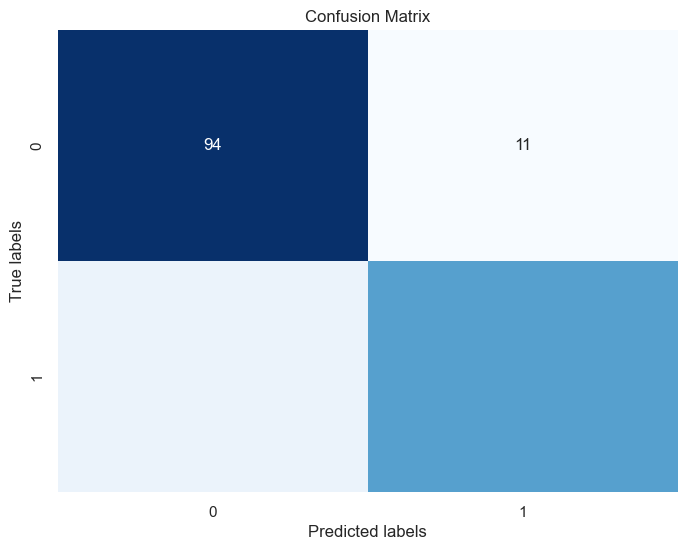

confusion matrix score: [[94 11]
 [16 58]]


In [103]:
conf_matrix(y_test=y_test, y_preds=y_preds)

## Let's once again test `RandomForestClassifier`

In [104]:
# Creating RandomForestClassifier predictions
rf_y_preds = tuned_rf.predict(X_test)

In [105]:
show_scores(y_test=y_test, y_preds=rf_y_preds)


    Accuracy score: 0.8435754189944135,
    Precision: 0.8382352941176471,
    Recall score: 0.7702702702702703,
    F1 score: 0.8028169014084507
    


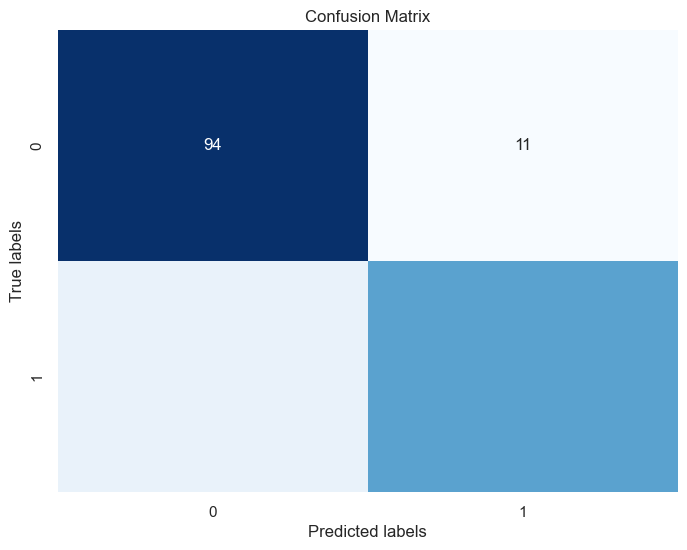

confusion matrix score: [[94 11]
 [17 57]]


In [106]:
conf_matrix(y_test=y_test, y_preds=rf_y_preds)

## Making predictions on our Test Data

In [107]:
test_df = pd.read_csv('test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [108]:
test_df = preprocessed_data(test_df)

In [110]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,207,2,34.5,0,0,153,7.8292,77,2
1,893,3,404,1,47.0,1,0,222,7.0000,77,3
2,894,2,270,2,62.0,0,0,74,9.6875,77,2
3,895,3,409,2,27.0,0,0,148,8.6625,77,3
4,896,3,179,1,22.0,1,1,139,12.2875,77,3


In [113]:
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

In [114]:
test_df.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### We had some missing data in our test dataset, so we made sure to eliminate this problem.

In [116]:
# Making predictions
test_preds = grd_clf.predict(test_df)
test_preds[:10]

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0], dtype=int64)

In [117]:
predictions = pd.DataFrame()
predictions['PassengerId'] = test_df['PassengerId']
predictions['Survived'] = test_preds
predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [127]:
# save our results
predictions.to_csv('Titanic_Kaggle_predictions.csv', index=False)

## Feature importances

In [120]:
grd_clf.feature_importances_

array([0.08544452, 0.06533688, 0.09816691, 0.28710401, 0.09255738,
       0.03085244, 0.00968746, 0.12313236, 0.12643344, 0.06823881,
       0.01304579])

In [125]:
def plot_features(columns, importances, n=11):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))

    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:11])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

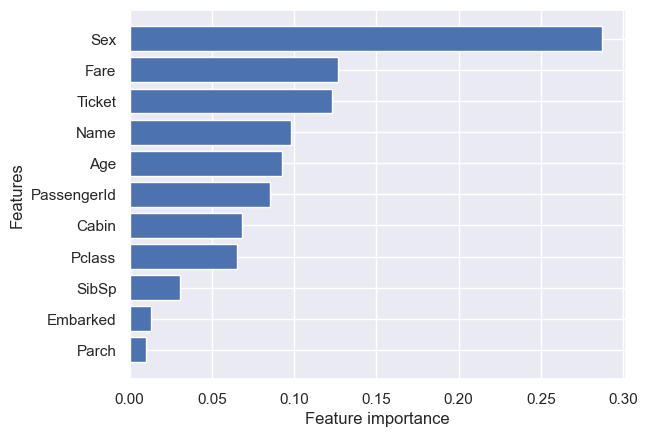

In [128]:
plot_features(X_train.columns, grd_clf.feature_importances_)